# Предсказание пола клиента по его транзакциям

In [36]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm_notebook
from warnings import filterwarnings
filterwarnings('ignore')


## Загрузка данных

In [37]:
tr_mcc_codes = pd.read_csv('data/mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('data/trans_types.csv', sep=';', index_col='trans_type')
transactions = pd.read_csv('data/transactions.csv', index_col='client_id')
gender_train = pd.read_csv('data/train.csv', index_col='client_id')
gender_test = pd.read_csv('data/test.csv', index_col='client_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [38]:
transactions_train

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,Unnamed: 0,gender
client_id,,,,,,,,
0002cf30347684df542e1a931f356875,313 14:52:03,4829,2370,-2170.07,888990,Saint Petersburg,6806,0
0002cf30347684df542e1a931f356875,150 14:10:49,6011,2010,-1445.64,NaN,Saint Petersburg,6806,0
0002cf30347684df542e1a931f356875,122 12:38:32,5912,1010,-107.07,NaN,Saint Petersburg,6806,0
0002cf30347684df542e1a931f356875,159 13:22:34,6011,2010,-2892.86,NaN,Saint Petersburg,6806,0
0002cf30347684df542e1a931f356875,257 12:06:54,5912,1010,-164.49,469965,Saint Petersburg,6806,0
...,...,...,...,...,...,...,...,...
fffedf876a0ea3d39e54b706165a4826,28 12:51:47,6011,2010,-10846.43,NaN,Saint Petersburg,3421,1
fffedf876a0ea3d39e54b706165a4826,55 07:37:08,6011,2010,-2170.15,NaN,Saint Petersburg,3421,1
fffedf876a0ea3d39e54b706165a4826,55 07:40:10,4814,1030,-71.41,NaN,Saint Petersburg,3421,1


## Анализ данных

#### transactions.csv

Этот файл содержит информацию о всех транзакциях пользователей без указания принадлежности к классу.

In [39]:
print(transactions.info())
print('\n')
print(transactions.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 3563529 entries, d1bbbc9a0e0410d3cf12a3d2f44f3450 to 8d69e4ecae4b509d528b9a0168f749d0
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   trans_time  object 
 1   mcc_code    int64  
 2   trans_type  int64  
 3   amount      float64
 4   term_id     object 
 5   trans_city  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 222.6+ MB
None


trans_time          0
mcc_code            0
trans_type          0
amount              0
term_id       1443778
trans_city          0
dtype: int64


В столбце <code>term_id</code> присутствует большое количество пропущенных значений. Использовать его в обучении модели бессмысленно.

#### tr_mcc_codes.csv

В файле присутствуют описания всех MCC кодов.

In [40]:
tr_mcc_codes.head()

,mcc_description
mcc_code,
742,Ветеринарные услуги
1711,"Генеральные подрядчики по вентиляции, теплосна..."
1731,Подрядчики по электричеству
1799,"Подрядчики, специализированная торговля — нигд..."
2741,Разнообразные издательства/печатное дело


#### tr_types.csv

Файл содержит описание всех типов транзакций.

In [41]:
tr_types.head()

,trans_description
trans_type,
3200,Плата за предоставление услуг посредством моби...
3210,Плата за предоставление отчета по счету карты ...
3800,Плата за обслуживание банковской карты (за пер...
4000,Плата за получение наличных в Сбербанке
4001,Плата за получение наличных в Сбербанке (в дру...


<code>gender_train</code> - пользователи, принадлежащие к тренировочной выборке

<code>gender_test</code> - пользователи, принадлежащие к тестовой выборке

<Axes: >

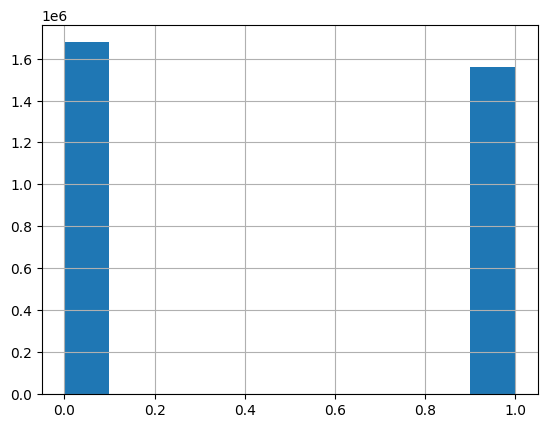

In [42]:
# Соотношение классов
transactions_train.gender.hist()

Этот датасет достаточно сбалансирован по классам.

Text(0, 0.5, 'Количество')

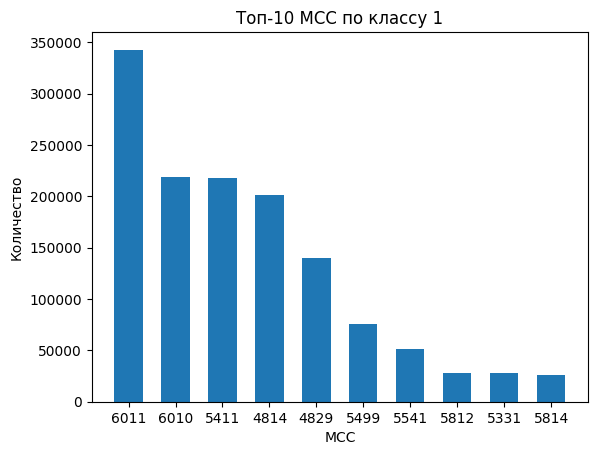

In [43]:
x_mcc_1 = transactions_train[transactions_train.gender == 1].mcc_code.value_counts().head(10).index.astype(str)
y_mcc_1 = transactions_train[transactions_train.gender == 1].mcc_code.value_counts().head(10).values

plt.bar(x_mcc_1, y_mcc_1, width=0.6)
plt.title('Топ-10 MCC по классу 1')
plt.xlabel('MCC')
plt.ylabel('Количество')

* Самый используемый mcc_code - это Финансовые институты — снятие наличности автоматически (то есть чаще всего люди 1 класса снимали наличные в банокамтах)
* 6010 - на втором месте. Снятие наличностей вручную с использованием карты (банки,кассы)
* 5411 - бакалейные лавки и супермаркеты
* 4814 Звонки с использованием телефонов, считывающих магнитную ленту



##### MCC_code класса 1

In [44]:
print('6011:',tr_mcc_codes.loc[6011, 'mcc_description'])
print('6010:',tr_mcc_codes.loc[6010, 'mcc_description'])
print('5411:',tr_mcc_codes.loc[5411, 'mcc_description'])
print('4814:',tr_mcc_codes.loc[4814, 'mcc_description'])
print('4829:',tr_mcc_codes.loc[4829, 'mcc_description'])
print('5499:',tr_mcc_codes.loc[5499, 'mcc_description'])
print('5541:',tr_mcc_codes.loc[5411, 'mcc_description'])
print('5331:',tr_mcc_codes.loc[5331, 'mcc_description'])
print('6011:',tr_mcc_codes.loc[6010, 'mcc_description'])
print('5814:',tr_mcc_codes.loc[5814, 'mcc_description'])


6011: Финансовые институты — снятие наличности автоматически
6010: Финансовые институты — снятие наличности вручную
5411: Бакалейные магазины, супермаркеты
4814: Звонки с использованием телефонов, считывающих магнитную ленту
4829: Денежные переводы
5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов
5541: Бакалейные магазины, супермаркеты
5331: Универсальные магазины
6011: Финансовые институты — снятие наличности вручную
5814: Рестораны, закусочные


Text(0, 0.5, 'Количество')

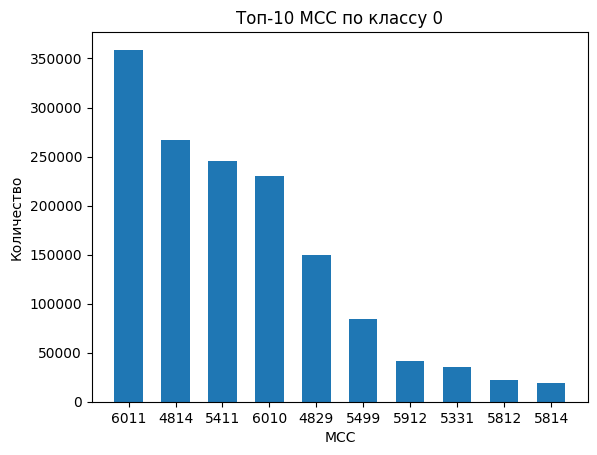

In [45]:
x_mcc_0 = transactions_train[transactions_train.gender == 0].mcc_code.value_counts().head(10).index.astype(str)
y_mcc_0 = transactions_train[transactions_train.gender == 0].mcc_code.value_counts().head(10).values

plt.bar(x_mcc_0, y_mcc_0, width=0.6)
plt.title('Топ-10 MCC по классу 0')
plt.xlabel('MCC')
plt.ylabel('Количество')

##### MCC_code класса 0

In [46]:
print('6011:',tr_mcc_codes.loc[6011, 'mcc_description'])
print('4814:',tr_mcc_codes.loc[4814, 'mcc_description'])
print('5411:',tr_mcc_codes.loc[5411, 'mcc_description'])
print('6010:',tr_mcc_codes.loc[6010, 'mcc_description'])
print('4829:',tr_mcc_codes.loc[4829, 'mcc_description'])
print('5499:',tr_mcc_codes.loc[5499, 'mcc_description'])
print('5912:',tr_mcc_codes.loc[5912, 'mcc_description'])
print('5331:',tr_mcc_codes.loc[5331, 'mcc_description'])
print('5812:',tr_mcc_codes.loc[5812, 'mcc_description'])
print('5814:',tr_mcc_codes.loc[5814, 'mcc_description'])

6011: Финансовые институты — снятие наличности автоматически
4814: Звонки с использованием телефонов, считывающих магнитную ленту
5411: Бакалейные магазины, супермаркеты
6010: Финансовые институты — снятие наличности вручную
4829: Денежные переводы
5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов
5912: Аптеки
5331: Универсальные магазины
5812: Места общественного питания, рестораны
5814: Рестораны, закусочные


Text(0, 0.5, 'Количество')

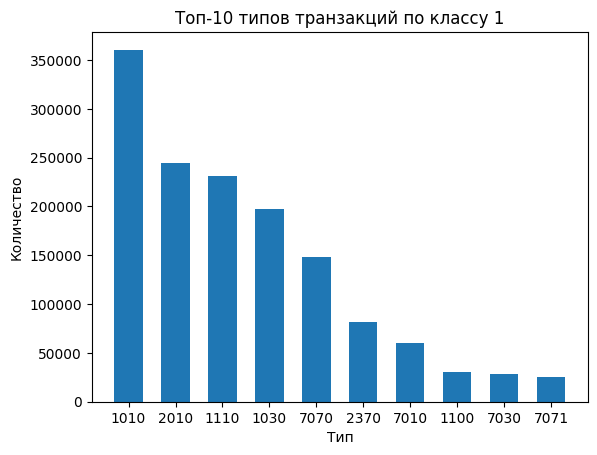

In [50]:
x_tr_1 = transactions_train[transactions_train.gender == 1]['trans_type'].value_counts().head(10).index.astype(str)
y_tr_1 = transactions_train[transactions_train.gender == 1]['trans_type'].value_counts().head(10).values

plt.bar(x_tr_1, y_tr_1, width=0.6)
plt.title('Топ-10 типов транзакций по классу 1')
plt.xlabel('Тип')
plt.ylabel('Количество')


In [53]:
print('1010:',tr_types.loc[1010, 'trans_description'])
print('2010:',tr_types.loc[2010, 'trans_description'])
print('1110:',tr_types.loc[1110, 'trans_description'])
print('1030:',tr_types.loc[1030, 'trans_description'])
print('7070:',tr_types.loc[7070, 'trans_description'])
print('2370:',tr_types.loc[2370, 'trans_description'])
print('7010:',tr_types.loc[7010, 'trans_description'])
print('1100:',tr_types.loc[1100, 'trans_description'])
print('7030:',tr_types.loc[7030, 'trans_description'])
print('7071:',tr_types.loc[7071, 'trans_description'])

1010: Покупка. POS ТУ СБ РФ
2010: Выдача наличных в АТМ Сбербанк России
1110: Покупка. POS ТУ Россия
1030: Оплата услуги. Банкоматы СБ РФ
7070: Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя)
2370: Списание с карты на карту по операции <перевода с карты на карту> через Мобильный банк (без комиссии)
7010: Взнос наличных через АТМ (в своем тер.банке)
1100: Покупка. ТУ  Россия
7030: Перевод на карту (с карты) через АТМ (в пределах одного тер.банка)
7071: Перевод на карту (с карты) через Мобильный банк (с взиманием комиссии с отправителя)


Text(0, 0.5, 'Количество')

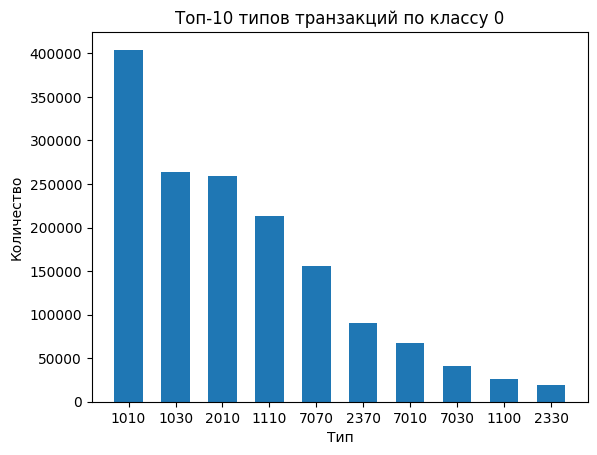

In [54]:
x_tr_0 = transactions_train[transactions_train.gender == 0]['trans_type'].value_counts().head(10).index.astype(str)
y_tr_0 = transactions_train[transactions_train.gender == 0]['trans_type'].value_counts().head(10).values

plt.bar(x_tr_0, y_tr_0, width=0.6)
plt.title('Топ-10 типов транзакций по классу 0')
plt.xlabel('Тип')
plt.ylabel('Количество')


In [56]:
print('1010:',tr_types.loc[1010, 'trans_description'])
print('1030:',tr_types.loc[1030, 'trans_description'])
print('2010:',tr_types.loc[2010, 'trans_description'])
print('1110:',tr_types.loc[1110, 'trans_description'])
print('7070:',tr_types.loc[7070, 'trans_description'])
print('2370:',tr_types.loc[2370, 'trans_description'])
print('7010:',tr_types.loc[7010, 'trans_description'])
print('7030:',tr_types.loc[7030, 'trans_description'])
print('1100:',tr_types.loc[1100, 'trans_description'])
print('2330:',tr_types.loc[2330, 'trans_description'])

1010: Покупка. POS ТУ СБ РФ
1030: Оплата услуги. Банкоматы СБ РФ
2010: Выдача наличных в АТМ Сбербанк России
1110: Покупка. POS ТУ Россия
7070: Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя)
2370: Списание с карты на карту по операции <перевода с карты на карту> через Мобильный банк (без комиссии)
7010: Взнос наличных через АТМ (в своем тер.банке)
7030: Перевод на карту (с карты) через АТМ (в пределах одного тер.банка)
1100: Покупка. ТУ  Россия
2330: Списание с карты по операции “перевода с карты на карту” через АТМ (в пределах одного тер.банка)


## Генерация фичей

Для тренировки модели, создадим временные фичи:
- Номер дня в месяце
- Месяц
- День
- Час
- Тип дня (будни, пятница, выходные)
- Время суток (утро, день, вечер, ночь)

In [66]:
def conditions_day(x):
    if x == 4:
        return 'friday'
    elif (x == 5 or x == 6):
        return 'weekend'
    else:
        return 'weekday'
conds_d = np.vectorize(conditions_day)

def conditions_hour(x):
    if (x >= 6) and (x < 12):
        return 'morning'
    elif (x >= 12) and (x < 18):
        return 'daytime'
    elif (x >= 18) and (x <= 23):
        return 'evening'
    else:
        return 'night'
conds_h = np.vectorize(conditions_hour)

for df in [transactions_train, transactions_test]:
    df['day_month'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) % 30)
    df['month'] = df['trans_time'].str.split().apply(lambda x: (int(x[0]) // 30) % 12)
    df['day'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['trans_time'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    type_day = conds_d(df['day'])
    df['type_day'] = type_day
    part_day = conds_h(df['hour'])
    df['part_day'] = part_day

transactions_train.head()

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,Unnamed: 0,gender,day_month,month,day,hour,type_day,part_day
client_id,,,,,,,,,,,,,,
0002cf30347684df542e1a931f356875,313 14:52:03,4829,2370,-2170.07,888990,Saint Petersburg,6806,0,13,10,5,14,weekend,daytime
0002cf30347684df542e1a931f356875,150 14:10:49,6011,2010,-1445.64,NaN,Saint Petersburg,6806,0,0,5,3,14,weekday,daytime
0002cf30347684df542e1a931f356875,122 12:38:32,5912,1010,-107.07,NaN,Saint Petersburg,6806,0,2,4,3,12,weekday,daytime
0002cf30347684df542e1a931f356875,159 13:22:34,6011,2010,-2892.86,NaN,Saint Petersburg,6806,0,9,5,5,13,weekend,daytime
0002cf30347684df542e1a931f356875,257 12:06:54,5912,1010,-164.49,469965,Saint Petersburg,6806,0,17,8,5,12,weekend,daytime


Посчитаем для каждого пользователя количество транзакций в определенные часы, дни, месяцы. Разделим транзакции на положительные (пришли средства) и отрицательные (ушли средства), а затем на основе этого посчитаем для каждого пользователя минимум, максимум, среднее, медиану и другие агрегирующие функции. Также, посчитаем количество транзакций по MCC кодам и типам транзакций.

In [70]:
tqdm_notebook.pandas(desc="Progress:")

def features_advanced(x): 
    features = []
    features.append(pd.Series(x['day_month'].value_counts(normalize=True).add_prefix('day_month_')))
    features.append(pd.Series(x['month'].value_counts(normalize=True).add_prefix('month_')))
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['type_day'].value_counts(normalize=True).add_prefix('type_day_')))
    features.append(pd.Series(x['part_day'].value_counts(normalize=True).add_prefix('part_day_')))
    
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('negative_transactions_')))

    features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_')))
    features.append(pd.Series(x['trans_type'].value_counts(normalize=True).add_prefix('tr_')))
    features.append(pd.Series(x[['day_month', 'part_day']].value_counts(normalize=True).add_prefix('dm_pd_')))
    
    return pd.concat(features)

In [71]:
data_train = transactions_train.groupby(transactions_train.index)\
                            .progress_apply(features_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                            .progress_apply(features_advanced).unstack(-1)

target = data_train.join(gender_train, how='inner')['gender']
target.value_counts()

Progress::   0%|          | 0/7560 [00:00<?, ?it/s]

Progress::   0%|          | 0/840 [00:00<?, ?it/s]

gender
0    4199
1    3361
Name: count, dtype: int64

In [72]:
X = data_train.copy()
y = target
test_df = data_test.copy()

# Заполним пустые значения нулями
X.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

X.shape, test_df.shape

((7560, 473), (840, 462))

## Модель

In [73]:
# Подобранные оптимальные гиперпараметры

params = {
    'num_trees': 270,
    'learning_rate': 0.08,
    'depth': 6,
    'l2_leaf_reg': 2.5,
    'verbose' : False
}

Оценим модель по метрикам ROC AUC и F1.

In [74]:
train_indices, test_indices = train_test_split(y.index, test_size=0.2)

train_x = X.loc[train_indices, :]
train_y = y.loc[train_indices]

test_x = X.loc[test_indices, :]
test_y = y.loc[test_indices]

model = CatBoostClassifier(**params)
model.fit(train_x, train_y)

In [75]:
y_pred = model.predict(test_x)
metric_auc = roc_auc_score(test_y, y_pred)
metric_f1 = f1_score(test_y, y_pred)

print('ROC AUC:', metric_auc)
print('F1 score:', metric_f1)

ROC AUC: 0.7794653222856597
F1 score: 0.753030303030303


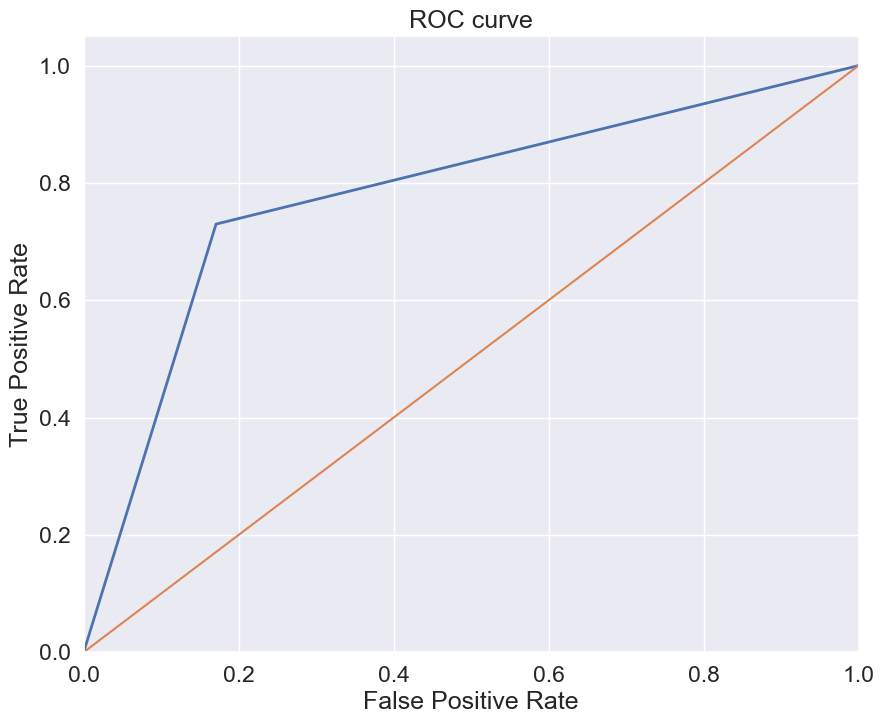

In [76]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(test_y, y_pred, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Обучим модель на всех данных

In [77]:
pred_model = CatBoostClassifier(**params)

pred_model.fit(X, y)

In [79]:
# Получение имен признаков из тестового набора данных
test_feature_names = test_df.columns.tolist()

# Получение имен признаков из обученной модели
model_feature_names = pred_model.feature_names_

# Сравнение имен признаков
if test_feature_names != model_feature_names:
    print("Список признаков не совпадает.")
    # Вывести различия между списками
    print(set(test_feature_names) - set(model_feature_names))


Список признаков не совпадает.
{('dm_pd_24', 'dm_pd_daytime'), ('dm_pd_16', 'dm_pd_daytime'), ('dm_pd_14', 'dm_pd_night'), ('dm_pd_21', 'dm_pd_morning'), ('dm_pd_26', 'dm_pd_morning'), ('dm_pd_7', 'dm_pd_evening'), ('dm_pd_10', 'dm_pd_daytime'), ('dm_pd_13', 'dm_pd_daytime'), ('dm_pd_18', 'dm_pd_night'), ('dm_pd_23', 'dm_pd_daytime'), ('dm_pd_1', 'dm_pd_daytime'), ('dm_pd_22', 'dm_pd_night'), ('dm_pd_2', 'dm_pd_morning'), ('dm_pd_18', 'dm_pd_morning'), ('dm_pd_11', 'dm_pd_evening'), ('dm_pd_7', 'dm_pd_daytime'), ('dm_pd_24', 'dm_pd_evening'), ('dm_pd_16', 'dm_pd_evening'), ('dm_pd_15', 'dm_pd_daytime'), ('dm_pd_3', 'dm_pd_night'), ('dm_pd_24', 'dm_pd_morning'), ('dm_pd_27', 'dm_pd_night'), ('dm_pd_0', 'dm_pd_daytime'), ('dm_pd_6', 'dm_pd_daytime'), ('dm_pd_10', 'dm_pd_evening'), ('dm_pd_29', 'dm_pd_daytime'), ('dm_pd_20', 'dm_pd_daytime'), ('dm_pd_13', 'dm_pd_evening'), ('dm_pd_12', 'dm_pd_daytime'), ('dm_pd_26', 'dm_pd_night'), ('dm_pd_27', 'dm_pd_morning'), ('dm_pd_23', 'dm_pd_evenin

In [78]:
predict = pred_model.predict_proba(test_df)

CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 187 should be feature with name mcc_3501 (found mcc_4111).

In [ ]:
submission = pd.DataFrame(index=data_test.index)
submission['probability'] = predict[:,1]
submission.to_csv('final_submission.csv')
submission.head()

,probability
customer_id,
6815,0.460374
27914,0.811062
31385,0.072757
38084,0.019044
78659,0.659438
